<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#fasttext-models" data-toc-modified-id="fasttext-models-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>fasttext models</a></span></li><li><span><a href="#networks" data-toc-modified-id="networks-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>networks</a></span></li></ul></div>

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import pandas as pd
import pickle

from gensim.models.fasttext import FastText
from keras.models import Sequential, Model
from keras.layers import Dense, Embedding, Input, Concatenate, Reshape, LSTM, GRU
from keras.optimizers import Adam
from keras.preprocessing.text import text_to_word_sequence

from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import hyperopt.pyll.stochastic

from statsmodels.tsa.stattools import adfuller

import matplotlib.pyplot as plt

%matplotlib inline

Using TensorFlow backend.


# fasttext models

In [37]:
data_type = 'news'
df_chats_raw = pd.read_csv('../data/clean_{0}.csv'.format(data_type))

if not 'timestamp' in df_chats_raw.columns:
    df_chats_raw.rename(columns={'date':'timestamp'}, inplace=True)#.head()#['timestamp']

In [38]:
class SentenceIterator(object):
    texts = None

    def __init__(self, texts):
        self.texts = texts

    def __iter__(self):
        for text in self.texts:
            yield text_to_word_sequence(text, lower=False)

In [39]:
def build_fasttext(size=100):
    path = '../data/fasttext_{0}_{1}.pkl'.format(data_type, size)
    if os.path.exists(path):
        m = FastText.load(path)
    else:
        m = FastText(SentenceIterator(df_chats_raw['clean_text']), min_count=5, size=size, workers=-1)
        m.save(path)
    return m

In [40]:
def text2vec(text, m=None, size=None):
    vectors = []
    for word in text_to_word_sequence(text):
        try:
            v = m.wv[word]
            vectors.append(v)
        except Exception as e:
            pass
    if not vectors:
        return np.zeros((size, ))
    return sum(vectors) / len(vectors)

In [41]:
def build_vectors(texts, size=None):
    t_model = build_fasttext(size)
    vectors = list(map(lambda x: text2vec(x, m=t_model, size=size), texts))
    return np.array(vectors)

# networks

In [42]:
TICKER = 'ETH'

In [43]:
df_prices_raw = pd.read_csv('../data/train/tickers_train.csv', index_col=0)

In [44]:
df_prices_raw['timestamp'] = pd.to_datetime(df_prices_raw['datetime']).apply(lambda x: x.timestamp())

In [45]:
df_prices = df_prices_raw[df_prices_raw['ticker'] == TICKER].copy()

In [46]:
df_chats = df_chats_raw[df_chats_raw['clean_text'].str.contains(TICKER.lower())].copy()
print('df_chats.shape :', df_chats.shape)

df_chats.shape : (785, 11)


In [47]:
if 'chat_id' in df_chats.columns:
    chat_ids = list(df_chats['chat_id'].unique())
    chat_ids.sort()
    chat2ind = {chat_id: i for i, chat_id in enumerate(chat_ids)}
    df_chats['chat_ind'] = df_chats['chat_id'].apply(lambda x: chat2ind[x])
else:
    chat2ind = None

if 'sender_id' in df_chats.columns:
    sender_ids = list(df_chats['sender_id'].unique())
    sender_ids.sort()
    sender2ind = {sender_id: i for i, sender_id in enumerate(sender_ids)}
    df_chats['sender_ind'] = df_chats['sender_id'].apply(lambda x: sender2ind[x])
else:
    sender2ind = None

In [48]:
df_chats['ind'] = list(range(df_chats.shape[0]))

In [49]:
vectors100 = build_vectors(df_chats['clean_text'], size=100)

In [50]:
vectors160 = build_vectors(df_chats['clean_text'], size=160)

In [51]:
vectors60 = build_vectors(df_chats['clean_text'], size=60)

In [240]:
def build_dataset(samples=5, steps=32, vectors=None):
    
    target_min_up=1.1
    target_max_down=0.95
    hours_before=48
    hours_after=48
    
    np.random.seed(0)
    
    inp_fasttext = []
    inp_chat_ind = []
    inp_sender_ind = []
    inp_timedelta_log = []
    out_target = [] # grow more than 0.66 quantile, not drawdown less 0.33 quantile in period 48 hours
    
    for i, row in df_prices.iterrows():
        ts = row['timestamp']
        if df_chats[
                (df_chats['timestamp'] > ts - hours_before * 3600) & 
                (df_chats['timestamp'] < ts)].shape[0] == 0:
            continue

        for sample in range(samples):
            ts = row['timestamp']

#             print(ts - hours_before * 3600, ts, hours_before)
            df_chats_sample = df_chats[
                (df_chats['timestamp'] > ts - hours_before * 3600) & 
                (df_chats['timestamp'] < ts)].sample(steps, replace=True)
            df_chats_sample['timedelta'] = np.log(-(df_chats_sample['timestamp'] - ts))

            chat_indexes = df_chats_sample['ind'].values

            batch_fasttext = vectors[chat_indexes]
            batch_timedelta = df_chats_sample['timedelta'].values

            if not chat2ind is None:
                batch_chat_ind = df_chats.iloc[chat_indexes]['chat_ind'].values
                inp_chat_ind.append(batch_chat_ind)

            if not sender2ind is None:
                batch_sender_ind = df_chats.iloc[chat_indexes]['sender_ind'].values
                inp_sender_ind.append(batch_sender_ind)

            df_prices_forward = df_prices[
                (df_prices['timestamp'] > ts) & 
                (df_prices['timestamp'] <= ts + hours_after * 3600)].copy()
            df_prices_forward = df_prices_forward.sort_values('timestamp')

            if df_prices_forward.shape[0] < int(hours_after / 2):
                continue
            df_prices_forward['priceUsd'] /= df_prices_forward['priceUsd'].values[0]

            target = False
            for price_relative in df_prices_forward['priceUsd'].values:
                if price_relative < target_max_down:
                    target = False
                    break
                if price_relative > target_min_up:
                    target = True
                    break

            inp_fasttext.append(batch_fasttext)
#             inp_chat_ind.append(batch_chat_ind)
#             inp_sender_ind.append(batch_sender_ind)
            inp_timedelta_log.append(batch_timedelta)
            out_target.append(target)
    
    inp_fasttext = np.array(inp_fasttext)
    inp_chat_ind = np.array(inp_chat_ind)
    inp_sender_ind = np.array(inp_sender_ind)
    inp_timedelta_log = np.array(inp_timedelta_log)

    out_target = np.array(out_target)
    
    inp_chat_ind = np.expand_dims(inp_chat_ind, 2)
    inp_sender_ind = np.expand_dims(inp_sender_ind, 2)
    inp_timedelta_log = np.expand_dims(inp_timedelta_log, 2)

    test_size = int(inp_fasttext.shape[0] * 0.1)
    
    X_train = [inp_fasttext[:-test_size]]\
        + ([] if chat2ind is None else inp_chat_ind[:-test_size])\
        + ([] if sender2ind is None else inp_sender_ind[:-test_size])\
        + [inp_timedelta_log[:-test_size]]

    Y_train = out_target[:-test_size]
    validation_data=[

        [inp_fasttext[-test_size:]]
        + ([] if chat2ind is None else inp_chat_ind[-test_size:])\
        + ([] if sender2ind is None else inp_sender_ind[-test_size:])\
        + [inp_timedelta_log[-test_size:]],

        out_target[-test_size:]

    ]
    
    return X_train, Y_train, validation_data

# X1, Y1, val1 = build_dataset(samples=5, steps=32, vectors=vectors100)
# # # 1519689600.0 1519862400.0 48
# ts = 1519862400.0
# hours_before = 48
# steps=32
# # df_chats[(df_chats['timestamp'] > ts - hours_before * 3600) &
# #     (df_chats['timestamp'] < ts)].sample(steps, replace=True)
# # df = pd.DataFrame(np.random.randn(50, 4), columns=list('ABCD'))
# print(df.head())
# print(df.sample(n=2, replace=True))
# print(df.head())

In [53]:
def build_nn(sender_size=128, chat_size=4, STEPS=None, lr=0.0001, fasttext_size=100):

    SENDER_EMBEDDING_SIZE = sender_size
    CHAT_EMBEDDING_SIZE = chat_size

    inp_layer_fasttext = Input(shape=(STEPS, fasttext_size, ), name='inp_layer_fasttext')
    # inp_layer_sender_bot = Input(shape=(STEPS, 1, ), name='inp_layer_sender_bot')

    inp_layer_timedelta = Input(shape=(STEPS, 1, ), name='inp_layer_timedelta')

    common_layer = Concatenate(axis=-1)([
        inp_layer_fasttext, inp_layer_timedelta])

    if not chat2ind is None:
        inp_layer_chat = Input(shape=(STEPS, 1, ), name='inp_layer_chat')
        chat_embedding = Embedding(len(chat2ind), CHAT_EMBEDDING_SIZE)(inp_layer_chat)
        chat_embedding = Reshape((STEPS, CHAT_EMBEDDING_SIZE))(chat_embedding)
        common_layer = Concatenate(axis=-1)([common_layer, chat_embedding])

    if not sender2ind is None:
        inp_layer_sender = Input(shape=(STEPS, 1, ), name='inp_layer_sender')
        sender_embedding = Embedding(len(sender2ind), SENDER_EMBEDDING_SIZE)(inp_layer_sender)
        sender_embedding = Reshape((STEPS, SENDER_EMBEDDING_SIZE))(sender_embedding)
        common_layer = Concatenate(axis=-1)([common_layer, sender_embedding])
        
#     common_layer = Concatenate(axis=-1)([
#         inp_layer_fasttext, chat_embedding, sender_embedding, inp_layer_timedelta])
    
    lstm = LSTM(8)(common_layer)
    # lstm = LSTM(8)(lstm)

    dense = Dense(1, activation='sigmoid')(lstm)

    model = Model( inputs=[inp_layer_fasttext, inp_layer_timedelta]
                            + [] if chat2ind is None else [inp_layer_chat]
                            + [] if sender2ind is None else [inp_layer_sender]
                    , outputs=dense
                )

    opt = Adam(lr=lr)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model
# model.compile(optimizer='sgd', loss='binary_crossentropy')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:76: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


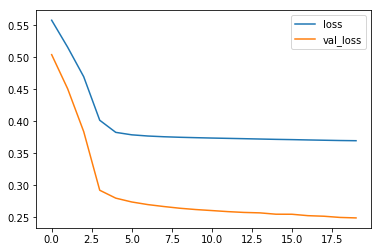

CPU times: user 1min 11s, sys: 13.4 s, total: 1min 24s
Wall time: 26 s


In [241]:
%%time 

np.random.seed(0)

model = build_nn(sender_size=128, chat_size=4, STEPS=32, lr=0.0001, fasttext_size=100)
X1, Y1, val1 = build_dataset(samples=5, steps=32, vectors=vectors100)
model.fit(X1, Y1, validation_data=val1, epochs=20, verbose=0)

plt.plot(model.history.history['loss'], label='loss')
plt.plot(model.history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

y_pred = model.predict(val1[0])
roc_auc_score(val1[1], y_pred)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:76: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


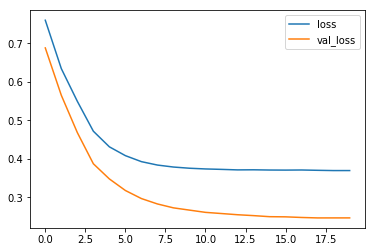

CPU times: user 1min 15s, sys: 14.1 s, total: 1min 29s
Wall time: 26.7 s


In [242]:
%%time 

np.random.seed(0)

model = build_nn(sender_size=128, chat_size=4, STEPS=32, lr=0.0001, fasttext_size=160)
X1, Y1, val1 = build_dataset(samples=5, steps=32, vectors=vectors160)
model.fit(X1, Y1, validation_data=val1, epochs=20, verbose=0)

plt.plot(model.history.history['loss'], label='loss')
plt.plot(model.history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

y_pred = model.predict(val1[0])
roc_auc_score(val1[1], y_pred)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:76: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


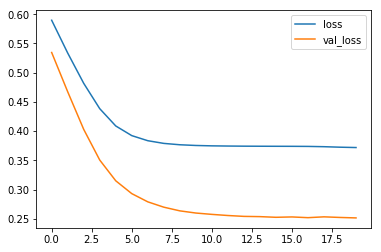

CPU times: user 1min 21s, sys: 15 s, total: 1min 36s
Wall time: 27.5 s


In [243]:
%%time 

np.random.seed(0)

model = build_nn(sender_size=128, chat_size=4, STEPS=32, lr=0.0001, fasttext_size=260)
X1, Y1, val1 = build_dataset(samples=5, steps=32, vectors=np.concatenate([vectors100, vectors160], axis=1))
model.fit(X1, Y1, validation_data=val1, epochs=20, verbose=0)

plt.plot(model.history.history['loss'], label='loss')
plt.plot(model.history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

y_pred = model.predict(val1[0])
roc_auc_score(val1[1], y_pred)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:76: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


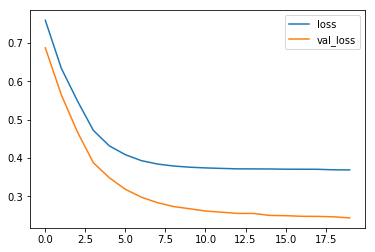

CPU times: user 1min 15s, sys: 14 s, total: 1min 29s
Wall time: 26.7 s


In [244]:
%%time 

np.random.seed(0)

model = build_nn(sender_size=128, chat_size=4, STEPS=32, lr=0.0001, fasttext_size=160)
X1, Y1, val1 = build_dataset(samples=5, steps=32, vectors=np.concatenate([vectors100, vectors60], axis=1))
model.fit(X1, Y1, validation_data=val1, epochs=20, verbose=0)

plt.plot(model.history.history['loss'], label='loss')
plt.plot(model.history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

y_pred = model.predict(val1[0])
roc_auc_score(val1[1], y_pred)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:76: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


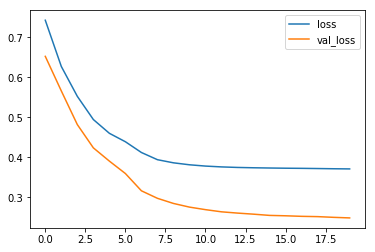

CPU times: user 1min 9s, sys: 13.4 s, total: 1min 22s
Wall time: 26.2 s


In [247]:
%%time 

np.random.seed(0)

model = build_nn(sender_size=128, chat_size=4, STEPS=32, lr=0.0001, fasttext_size=60)
X1, Y1, val1 = build_dataset(samples=5, steps=32, vectors=vectors60)
model.fit(X1, Y1, validation_data=val1, epochs=20, verbose=0)

plt.plot(model.history.history['loss'], label='loss')
plt.plot(model.history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

y_pred = model.predict(val1[0])
roc_auc_score(val1[1], y_pred)

In [249]:
with open('../data/train_test_{0}.pkl'.format(data_type), 'wb') as f:
    f.write(pickle.dumps({
        'x': X1,
        'y': Y1,
        'validation': val1,
    }))

# tune hyperparams

In [250]:
space = {
    'sender_size': hp.choice('sender_size', list(range(8, 256))),
    'chat_size': hp.choice('chat_size', list(range(2, 10))),
    'steps': hp.choice('steps', [32, 64, 128]),
    'lr': 10**hp.uniform('lr', -8, -2),
    'samples': hp.choice('samples', list(range(1, 10))),
}

In [251]:
x = hyperopt.pyll.stochastic.sample(space)

In [252]:
x

{'chat_size': 5,
 'lr': 9.26945643312855e-07,
 'samples': 7,
 'sender_size': 63,
 'steps': 64}

In [253]:
del x

In [254]:
def objective(x):
    
    np.random.seed(0)
    
    print(x)
    
    model = build_nn(
        sender_size=x['sender_size'], chat_size=x['chat_size'], STEPS=x['steps'], 
        lr=x['lr'], fasttext_size=100)
    X1, Y1, val1 = build_dataset(samples=x['samples'], steps=x['steps'], vectors=vectors100)
    model.fit(X1, Y1, validation_data=val1, epochs=20, verbose=0)
    
    y_pred = model.predict(val1[0])
    score = roc_auc_score(val1[1], y_pred)
    
    print('roc_auc', score)
    
    return {'loss': -score, 'status': STATUS_OK}

In [255]:
trials = Trials()

In [256]:
best = fmin(objective, space, algo=tpe.suggest, max_evals=20, trials=trials)

{'chat_size': 5, 'lr': 7.880351302781298e-07, 'samples': 8, 'sender_size': 216, 'steps': 32}


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:76: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


roc_auc 0.3241136128364389
{'chat_size': 8, 'lr': 0.0022476256369129395, 'samples': 5, 'sender_size': 200, 'steps': 32}
roc_auc 0.7983443708609271
{'chat_size': 9, 'lr': 9.598404173549202e-07, 'samples': 8, 'sender_size': 118, 'steps': 32}
roc_auc 0.30884446169772256
{'chat_size': 2, 'lr': 0.0021586517607293317, 'samples': 8, 'sender_size': 210, 'steps': 64}
roc_auc 0.8045419254658385
{'chat_size': 3, 'lr': 7.51036279571022e-05, 'samples': 4, 'sender_size': 158, 'steps': 32}
roc_auc 0.7684128630705394
{'chat_size': 9, 'lr': 3.576714829120848e-08, 'samples': 1, 'sender_size': 155, 'steps': 64}
roc_auc 0.3833333333333333
{'chat_size': 8, 'lr': 2.0116933880343217e-05, 'samples': 7, 'sender_size': 18, 'steps': 32}
roc_auc 0.8025558564658091
{'chat_size': 6, 'lr': 0.0025405417861579377, 'samples': 9, 'sender_size': 124, 'steps': 32}
roc_auc 0.8005422549621445
{'chat_size': 6, 'lr': 1.5190587913557036e-08, 'samples': 3, 'sender_size': 129, 'steps': 32}
roc_auc 0.5161141804788214
{'chat_size'

In [257]:
best

{'chat_size': 3,
 'lr': -2.2221173906103697,
 'samples': 0,
 'sender_size': 119,
 'steps': 0}

In [258]:
{'chat_size': 5, 'lr': 0.000033215565785761354, 'samples': 5, 'sender_size': 213, 'steps': 128}
# roc_auc 0.7789987789987789

{'chat_size': 5,
 'lr': 3.3215565785761354e-05,
 'samples': 5,
 'sender_size': 213,
 'steps': 128}

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:76: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


Train on 2898 samples, validate on 322 samples
Epoch 1/20
2898/2898 [==============================] - 5s 2ms/step - loss: 0.5728 - acc: 0.8758 - val_loss: 0.5412 - val_acc: 0.9379
Epoch 2/20
2898/2898 [==============================] - 3s 1ms/step - loss: 0.5587 - acc: 0.8758 - val_loss: 0.5245 - val_acc: 0.9379
Epoch 3/20
2898/2898 [==============================] - 3s 1ms/step - loss: 0.5453 - acc: 0.8758 - val_loss: 0.5084 - val_acc: 0.9379
Epoch 4/20
2898/2898 [==============================] - 3s 1ms/step - loss: 0.5324 - acc: 0.8758 - val_loss: 0.4924 - val_acc: 0.9379
Epoch 5/20
2898/2898 [==============================] - 3s 1ms/step - loss: 0.5195 - acc: 0.8758 - val_loss: 0.4756 - val_acc: 0.9379
Epoch 6/20
2898/2898 [==============================] - 3s 1ms/step - loss: 0.5057 - acc: 0.8758 - val_loss: 0.4572 - val_acc: 0.9379
Epoch 7/20
2898/2898 [==============================] - 3s 1ms/step - loss: 0.4908 - acc: 0.8758 - val_loss: 0.4372 - val_acc: 0.9379
Epoch 8/20
2898

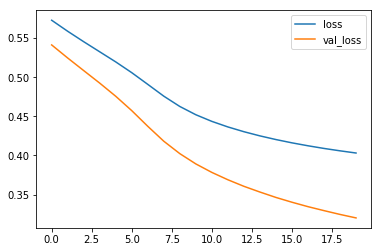

roc auc 0.508774834437086
CPU times: user 4min 8s, sys: 56.4 s, total: 5min 5s
Wall time: 1min 16s


In [259]:
%%time 

np.random.seed(0)

model = build_nn(sender_size=213, chat_size=5, STEPS=128, lr=0.00003, fasttext_size=100)
X1, Y1, val1 = build_dataset(samples=5, steps=128, vectors=vectors100)
model.fit(X1, Y1, validation_data=val1, epochs=20)

plt.plot(model.history.history['loss'], label='loss')
plt.plot(model.history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

y_pred = model.predict(val1[0])
score = roc_auc_score(val1[1], y_pred)

print('roc auc', score)

[]

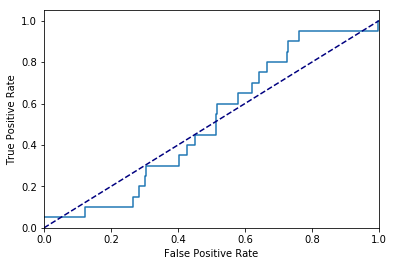

In [260]:
fpr, tpr, thresholds = roc_curve(val1[1], y_pred)

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot()

In [261]:
X2, Y2, val2 = build_dataset(samples=1, steps=128, vectors=vectors100)
y2_pred = model.predict(val2[0])[:, 0]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:76: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


In [262]:
for fp, tp, th in zip(fpr, tpr, thresholds):
    if tp > 0.6:
        print(th)
        break

0.2118088


In [263]:
(y2_pred > th).astype(np.int).shape

(64,)

In [264]:
(y2_pred > th).astype(np.int)

array([0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0,
       1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1])

In [265]:
model.save('../data/model_{0}_eth.pkl'.format(data_type))

# visualizations

In [266]:
e = model.layers[3]

In [267]:
weights = e.get_weights()[0]

In [268]:
weights.shape

(101, 32)

In [269]:
tsne = TSNE()

In [270]:
%%time
weights_tsne = tsne.fit_transform(weights)

CPU times: user 874 ms, sys: 652 ms, total: 1.53 s
Wall time: 852 ms


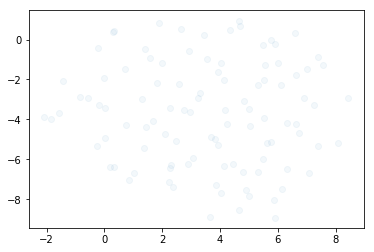

In [271]:
plt.scatter(weights_tsne[:, 0], weights_tsne[:, 1], alpha=0.05)
plt.show()

In [272]:
d = pd.DataFrame(weights_tsne, columns=['x', 'y'])

In [273]:
d['index'] = list(range(d.shape[0]))

In [274]:
center1 = [-10, 0]
center2 = [-20, 40]

In [275]:
d1 = []
d2 = []
for i, row in d.iterrows():
    d1.append((center1[0] - row['x']) ** 2 + (center1[1] - row['y']) ** 2)
    d2.append((center2[0] - row['x']) ** 2 + (center2[1] - row['y']) ** 2)
    
d['d1'] = d1
d['d2'] = d2

In [276]:
d.sort_values('d1')[:5]

,x,y,index,d1,d2
66,-1.425139,-2.058791,66,77.766856,2113.967344
46,-2.071774,-3.884500,46,77.946108,2247.270630
32,-1.853435,-3.958769,32,82.038366,2261.671165
97,-1.577859,-3.686393,97,84.521950,2247.876192
35,-0.826111,-2.892995,35,92.529657,2207.447060


In [277]:
d.sort_values('d2')[:5]

,x,y,index,d1,d2
2,0.329502,0.433391,2,106.886448,1978.805208
57,0.301665,0.369683,57,106.260968,1982.719664
77,1.874397,0.810626,77,141.658408,2014.296248
26,-0.223566,-0.411785,26,95.748230,2024.219692
10,2.659161,0.521192,10,160.525995,2072.013841


In [279]:
# df_chats[df_chats['sender_ind'].isin(d.sort_values('d1')[:5]['index'])]['text'].values

In [280]:
# df_chats[df_chats['sender_ind'].isin(d.sort_values('d2')[:5]['index'])]['text'].values

KeyError: 'sender_ind'

In [ ]:
prices = df_prices['priceUsd'].pct_change()[1:].values

In [ ]:
plt.hist(prices, bins=20)
plt.show()

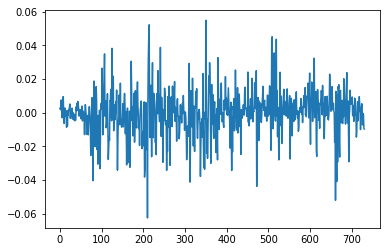

In [134]:
plt.plot(prices)

In [138]:
adfuller(prices)

(-8.535428772025405,
 1.0110438004829059e-13,
 6,
 724,
 {'1%': -3.4394144152232995,
  '5%': -2.8655403100177566,
  '10%': -2.5689002207655443},
 -4169.700082124158)

In [246]:
val1[-1].shape

(322,)